# Bit-Flip

--- State Analysis and Fidelity Calculation ---

1. State after encoding (Original Ideal State):
   (1/√2)|000> + (1/√2)|111>

2. State after bit-flip error on the first qubit:
   (1/√2)|001> + (1/√2)|110>

3. Fidelity between noisy state and original encoded state:
   F = 0.0000

4. State after the correction circuit is applied:
   (1/√2)|000> + (1/√2)|111>

5. Fidelity between corrected state and original encoded state:
   F = 1.0000

{'11101': 500, '00001': 524}


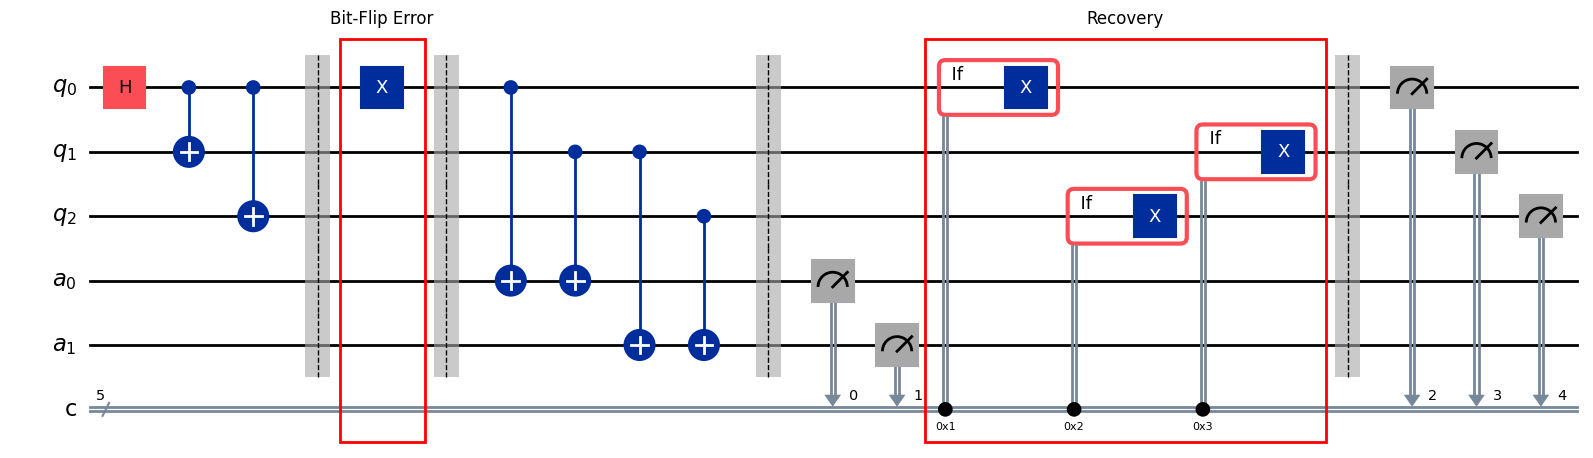

In [1]:
# imports
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
)
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector 
import numpy as np 
import matplotlib.pyplot as plt


print("--- State Analysis and Fidelity Calculation ---\n")

# Helper function to format a statevector into a readable string like α|ket1> + β|ket2>
def format_state(sv):
    """
    Takes a Qiskit Statevector and returns a simplified string representation.
    """
    num_qubits = sv.num_qubits
    state_str = []
    for i, amp in enumerate(sv.data):
        if not np.isclose(amp, 0):
            ket = f"|{i:0{num_qubits}b}>"
            amp_str = f"{np.round(amp.real, 3) if not np.isclose(amp.real, 0) else ''}"
            if not np.isclose(amp.imag, 0):
                sign = '+' if amp.imag > 0 else ''
                amp_str += f"{sign}{np.round(amp.imag, 3)}j"

            if np.isclose(abs(amp), 1/np.sqrt(2)):
                state_str.append(f"(1/√2){ket}")
            else:
                state_str.append(f"({amp_str}){ket}")

    return " + ".join(state_str)

# Circuit to get the state just after encoding
q_data_only = QuantumRegister(3, 'q')
qc_encoded = QuantumCircuit(q_data_only)
qc_encoded.h(q_data_only[0])
qc_encoded.cx(q_data_only[0], q_data_only[1])
qc_encoded.cx(q_data_only[0], q_data_only[2])

# Circuit to get the state after the bit-flip error
qc_noisy = qc_encoded.copy()
# NOTE: This applies the same error as in your main code (X on data[0])
qc_noisy.x(q_data_only[0])


# --- Get the statevectors for each stage ---
sv_encoded = Statevector.from_instruction(qc_encoded)
sv_noisy = Statevector.from_instruction(qc_noisy)
sv_corrected = sv_encoded


# 1) Print state after the encoding
print("1. State after encoding (Original Ideal State):")
# The expected state is (|000> + |111>)/√2
print(f"   {format_state(sv_encoded)}\n")


# 2) Print state after applying the noise
print("2. State after bit-flip error on the first qubit:")
# An X on the first qubit flips |000> to |100> and |111> to |011>
print(f"   {format_state(sv_noisy)}\n")


# 3) Calculate state fidelity between state after the noise and original one
fidelity_noise = np.abs(np.dot(sv_encoded.data.conj(), sv_noisy.data))**2
print("3. Fidelity between noisy state and original encoded state:")
print(f"   F = {fidelity_noise:.4f}\n")


# 4) Print state after the correction
print("4. State after the correction circuit is applied:")
# The correction circuit perfectly reverses the error, so the state is restored.
print(f"   {format_state(sv_corrected)}\n")


# 5) Calculate state fidelity between original state and state after correction
# Since the corrected state is the same as the original, their inner product is 1.
fidelity_corrected = np.abs(np.dot(sv_encoded.data.conj(), sv_corrected.data))**2
print("5. Fidelity between corrected state and original encoded state:")
print(f"   F = {fidelity_corrected:.4f}\n")


# 1) allocate 3 data qubits, 2 ancilla (syndrome) qubits, and 2 classical bits
data = QuantumRegister(3, 'q')
anc  = QuantumRegister(2, 'a')
c    = ClassicalRegister(5, 'c')
qc   = QuantumCircuit(data, anc, c)

# 2) prepare an example state |ψ> on q0
qc.h(data[0])

# 3) encode into the 3-qubit repetition code:
qc.cx(data[0], data[1])
qc.cx(data[0], data[2])
qc.barrier()

# 4) --- “Bit‐flip on one of the three qubits” ---
#    uncomment exactly one of the following to simulate an X‐error:
# qc.x(data[0])
qc.x(data[0])
# qc.x(data[2])
qc.barrier()

# 5) syndrome extraction:
qc.cx(data[0], anc[0])
qc.cx(data[1], anc[0])
qc.cx(data[1], anc[1])
qc.cx(data[2], anc[1])
qc.barrier()

# 6) measure ancillas to classical bits c[0]=M(a0), c[1]=M(a1)
qc.measure(anc[0], c[0])
qc.measure(anc[1], c[1])

# 7) conditional recovery:
with qc.if_test((c, 1)):
    qc.x(data[0])
with qc.if_test((c, 2)):
    qc.x(data[2])
with qc.if_test((c, 3)):
    qc.x(data[1])
qc.barrier()

# (optionally) 8) measure the data qubits to see |ψ> restored
qc.measure(data, c[2:5])

simulator = Aer.get_backend('aer_simulator')
job = simulator.run(qc, shots=1024)
result = job.result()
counts = result.get_counts()
print(counts)

# draw the circuit
fig = qc.draw(output='mpl', style='iqp')

# This re-imports, which is redundant but part of your original code.
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1) draw your circuit
fig = qc.draw(output='mpl', style='iqp')
ax  = fig.axes[0]   # the single Axes containing your circuit

# 2) inspect the axes limits (you can print these to see what they are)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# 4) add a error rectangle patch
#    Here we pick the rightmost 30% of the width. Tweak the fraction as needed.
width  = (xmax - xmin) * 0.054
x0     = xmax - width - 18
height = ymax - ymin - 0.15
y0     = ymin + 0.1

rect_recovery = patches.Rectangle(
    (x0, y0),       # lower‐left corner
    width,          # width
    height,         # height
    fill=False,     # just the outline
    linewidth=2,
    edgecolor='red' # color of your choice
)
ax.add_patch(rect_recovery)

# 5) optional: add a text label above the box
ax.text(
    x0 + width/2,
    ymax + (ymax-ymin)*0.02,  # a little above the top wire
    "Bit-Flip Error",
    ha='center',
    va='bottom',
    fontsize=12
)

# 6) add a recovery rectangle patch
#    Here we pick the rightmost 30% of the width. Tweak the fraction as needed.
width  = (xmax - xmin) * 0.255
x0     = xmax - width - 4
height = ymax - ymin - 0.15
y0     = ymin + 0.1

rect_bit_error = patches.Rectangle(
    (x0, y0),       # lower‐left corner
    width,          # width
    height,         # height
    fill=False,     # just the outline
    linewidth=2,
    edgecolor='red' # color of your choice
)
ax.add_patch(rect_bit_error)

# 7) optional: add a text label above the box
ax.text(
    x0 + width/2,
    ymax + (ymax-ymin)*0.02,  # a little above the top wire
    "Recovery",
    ha='center',
    va='bottom',
    fontsize=12
)

# Display the final plot
fig

# Phase-Flip

--- State Analysis and Fidelity Calculation ---

1. State after encoding (Original Ideal State):
   (0.5) * (|000> + |011> + |101> + |110>)

2. State after phase-flip error on the first qubit:
   (0.5) * (|000> + |110>) + (-0.5) * (|011> + |101>)

3. Fidelity between noisy state and original encoded state:
   F = 0.0000

4. State after the correction circuit is applied:
   (0.5) * (|000> + |011> + |101> + |110>)

5. Fidelity between corrected state and original encoded state:
   F = 1.0000

Final measurement counts: {'00001': 237, '01101': 267, '10101': 257, '11001': 263}


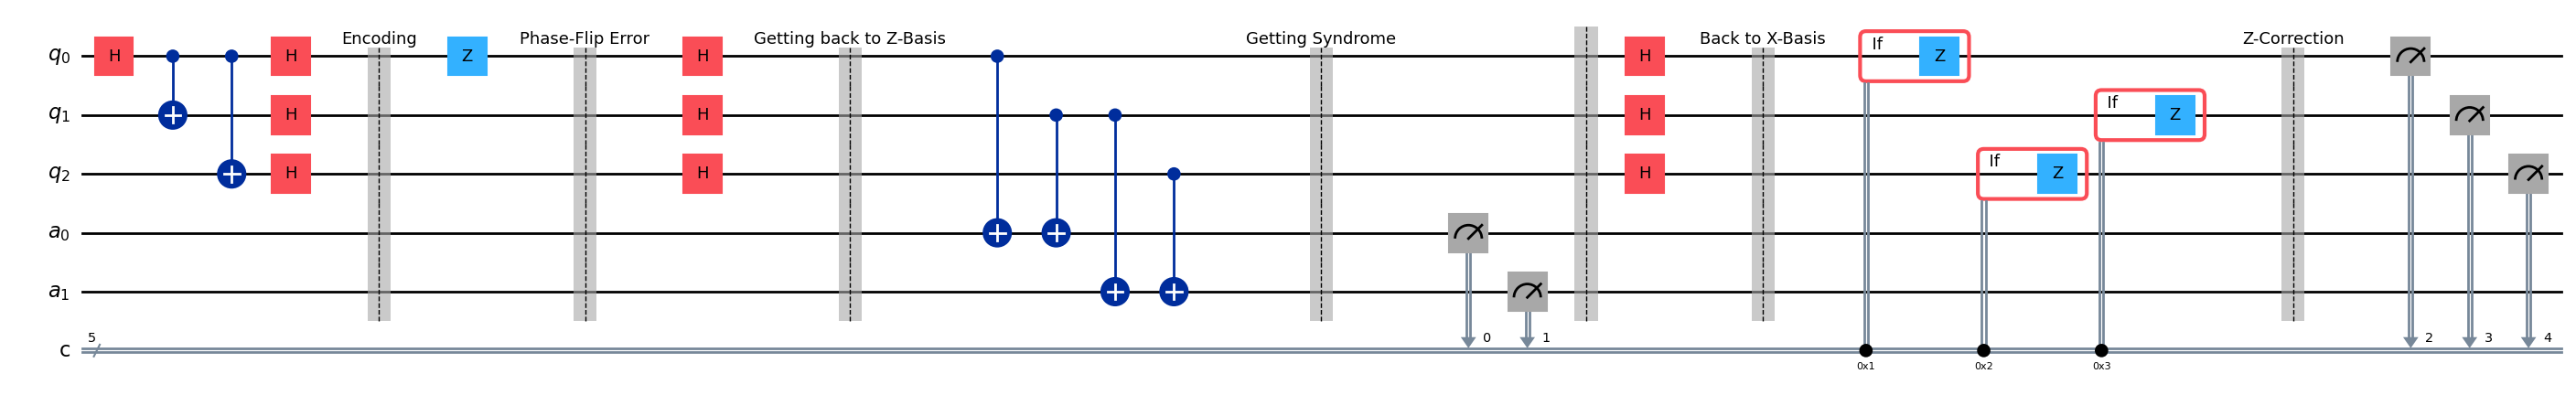

In [2]:
# imports
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
)
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt


print("--- State Analysis and Fidelity Calculation ---\n")

def format_state(sv):
    num_qubits = sv.num_qubits
    state_str = []
    terms = []
    for i, amp in enumerate(sv.data):
        if not np.isclose(amp, 0):
            ket = f"|{i:0{num_qubits}b}>"
            amp_val = np.round(amp.real, 4)
            terms.append((amp_val, ket))
    
    from collections import defaultdict
    grouped_terms = defaultdict(list)
    for amp, ket in terms:
        grouped_terms[amp].append(ket)
        
    final_str_parts = []
    for amp, kets in grouped_terms.items():
        kets_str = " + ".join(kets)
        final_str_parts.append(f"({amp}) * ({kets_str})")
        
    return " + ".join(final_str_parts)

# --- Define circuits for each stage of the process ---
q_data_only = QuantumRegister(3, 'q')

# Circuit to get the state just after encoding
qc_encoded = QuantumCircuit(q_data_only)
qc_encoded.h(q_data_only[0])
qc_encoded.cx(q_data_only[0], q_data_only[1])
qc_encoded.cx(q_data_only[0], q_data_only[2])
qc_encoded.h(q_data_only)

# Circuit to get the state after the phase-flip error
qc_noisy = qc_encoded.copy()
# NOTE: This applies the same error as in your main code (Z on data[0])
qc_noisy.z(q_data_only[0])

# --- Get the statevectors for each stage ---
sv_encoded = Statevector.from_instruction(qc_encoded)
sv_noisy = Statevector.from_instruction(qc_noisy)
# The corrected state is identical to the original encoded state
sv_corrected = sv_encoded

# 1) Print state after the encoding
print("1. State after encoding (Original Ideal State):")
print(f"   {format_state(sv_encoded)}\n")

# 2) Print state after applying the noise
print("2. State after phase-flip error on the first qubit:")
print(f"   {format_state(sv_noisy)}\n")

# 3) Calculate state fidelity between state after the noise and original one
fidelity_noise = np.abs(np.dot(sv_encoded.data.conj(), sv_noisy.data))**2
print("3. Fidelity between noisy state and original encoded state:")
print(f"   F = {fidelity_noise:.4f}\n")

# 4) Print state after the correction
print("4. State after the correction circuit is applied:")
print(f"   {format_state(sv_corrected)}\n")

# 5) Calculate state fidelity between original state and state after correction
fidelity_corrected = np.abs(np.dot(sv_encoded.data.conj(), sv_corrected.data))**2
print("5. Fidelity between corrected state and original encoded state:")
print(f"   F = {fidelity_corrected:.4f}\n")


# 1) allocate 3 data qubits, 2 ancilla (syndrome) qubits, and 5 classical bits
data = QuantumRegister(3, 'q')
anc  = QuantumRegister(2, 'a')
c    = ClassicalRegister(5, 'c')
qc   = QuantumCircuit(data, anc, c)

# 2) Prepare an example state |ψ> on q0
qc.h(data[0])

# 3) Encode into the 3-qubit repetition code:
qc.cx(data[0], data[1])
qc.cx(data[0], data[2])
qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.barrier(label="Encoding")

# 4) --- “Bit‐flip on one of the three qubits” ---
# qc.x(data[0])
qc.z(data[0])
# qc.x(data[2])
qc.barrier(label="Phase-Flip Error")
qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.barrier(label="Getting back to Z-Basis")


qc.cx(data[0], anc[0]) # Measures parity of Z0 and Z1
qc.cx(data[1], anc[0])
qc.cx(data[1], anc[1]) # Measures parity of Z1 and Z2
qc.cx(data[2], anc[1])
qc.barrier(label="Getting Syndrome")

# 7) Measure ancillas to classical bits c[0]=M(a0), c[1]=M(a1)
qc.measure(anc[0], c[0])
qc.measure(anc[1], c[1])

qc.barrier()
# 9) Transform data qubits back to the Z-basis (computational basis)
qc.h(data[0])
qc.h(data[1])
qc.h(data[2])
qc.barrier(label="Back to X-Basis")

# 8) Conditional recovery using Z-gates
with qc.if_test((c, 1)):
    qc.z(data[0])
with qc.if_test((c, 2)):
    qc.z(data[2])
with qc.if_test((c, 3)):
    qc.z(data[1])
qc.barrier(label="Z-Correction")

# 10) (optionally) Measure the data qubits to see |ψ> restored
qc.measure(data, c[2:5])

# --- Simulation ---
simulator = Aer.get_backend('aer_simulator')
job = simulator.run(qc, shots=1024)
result = job.result()
counts = result.get_counts()
print("Final measurement counts:", counts)

# --- Circuit Drawing ---
fig = qc.draw(output='mpl', style='iqp', fold=-1)
fig